# Hands On Session: Uncovering brain-behavior relationships and overcoming overfitting with regularization

In this section, we're going to use tools learnt in Section 1 and learn about methods to uncover relationships between hypothalamic neural activity and social behavior using a dataset from [Remedios et ., 2017, Nature](https://https://www.nature.com/articles/nature23885)

### Table of contents
#### 1 a) Visualizing neural data and behavior
#### 1 b) PCA on neural data
#### 2 a) Train test split 
#### 2 b) Performing linear regression
#### 2 c) Prediction and quatifying performance
#### 3 a) Overcoming overfitting: LASSO or L2 Norm
#### 3 b) Lasso model performance
#### 3 c) Overcoming overfitting: Ridge or L1 Norm
#### 3 d) Ridge model performance
#### 4) Class imbalance
#### 5) Logistic regression
#### 6 a) Digging deeper and implementing regression from scratch
#### 6 b) Testing our regression function
#### 7) Implementing regularization from scratch
#### 8) More details on regularization

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SaberaTalukder/Chen_Institute_DataSAI_for_Neuroscience/blob/main/07_05_22_day1_overview/code/diy_notebooks/overfitting_regularization.ipynb)

In [1]:
# Import neccessary modules and helper functions
# Sort imports alphabetically

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.decomposition import PCA
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from matplotlib import image
from sklearn.linear_model import LogisticRegression

def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
    

### But first!

A bit more about our dataset: the data you examined in part 1 comes from a head-mounting microendoscope which collected calcium imaging (GCaMP6s) data from a male mouse enaging in either mating behavior towards a female or aggressive behavior towards a male. After collection of the imaging data, a data extraction pipeline is used to identify cells and extract time evolving traces from the imaging video. Finally, experimenters perform computer-vision assisted annotation of behaviors to give you the behavior label binary vectors you are using today

<img src="vmhvl_recording.png" alt="Drawing" style="width: 500px;"/>

<!-- ![vmhvl_recording.png](attachment:vmhvl_recording.png) -->

### Load data

Just as before let's load this dataset

In [2]:

# data_path = '/home/sabra/Documents/Chen_Institute_DataSAI_for_Neuroscience/07_05_22_day1_overview/data/hypothalamus_calcium_imaging_remedios_et_al.mat'
# hypothalamus_data = loadmat(data_path);

remedios_data = loadmat("vmhvl_remedios_male.mat");
neural_data = remedios_data['neural_data']
attack_vector = remedios_data['attack_vector']


### 1 a) Visualize neural and behavior data 
Now that we've examined neural activity of VMHvl in session 1, let's plot both a behavior raster showing attack behavior (present in attack_vector) and neural activity together. 

Attack is a behavior causally linked to VMHvl activity: activation this hypothalamus brain region using optogenetic can produce aggression (see: [Lin et ., 2011, Nature](https://www.nature.com/articles/nature09736) for some cool videos)

<br>

#### Generate a plot showing the behavior annotation array attack_vector along with neural activity below:
##### hint: use imshow

In [3]:
# Enter code here:

Text(0, 0.5, 'neurons')

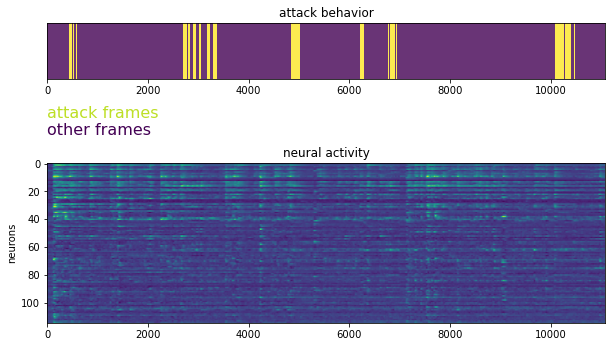

In [4]:
# Solution

# Plot behavior raster
plt.figure(figsize=[10,10])
ax1 = plt.subplot(311)
cmap = matplotlib.cm.get_cmap('viridis')

ax1.imshow(attack_vector, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior')
ax1.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax1.text(0,1.5,'other frames',color = cmap(0.0),fontsize=16)

ax2 = plt.subplot(312)
ax2.imshow(neural_data, aspect='auto')
ax2.set_title('neural activity')
ax2.set_ylabel('neurons')

### 1 b) Redo PCA!
As you can see, attack is a rare behavior. You have also quantified this in section 1 using histograms. Let's now use what we learnt in Section 1 to perform PCA on this data and examine the top 2 principal components. This time, let's color each data point by the behavior associated with it in the attack_vector annotation array

<br>

#### Generate a PCA plot colored by the behavior annotation array attack_vector below:

In [5]:
# Enter code here:

Text(0.02, 0.017, 'attack')

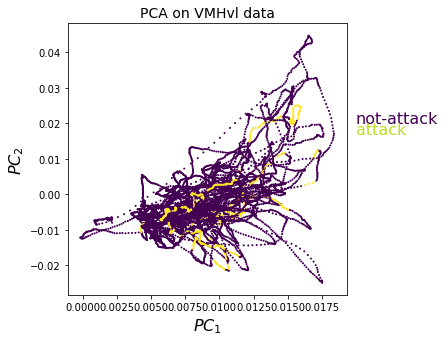

In [6]:
# Solution

# perform PCA
pca_neural = PCA(n_components=2)
pca_neural.fit_transform (neural_data)
neural_pcs = pca_neural.components_

# plot PCA, colored by intruder sex
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)
cmap = matplotlib.cm.get_cmap('viridis')

# neural_pcs.shape
ax.scatter(neural_pcs[0,],neural_pcs[1,], c = attack_vector, s = 1)
ax.set_title('PCA on VMHvl data',fontsize = 14)
ax.set_xlabel('$PC_1$',fontsize=16)
ax.set_ylabel('$PC_2$',fontsize=16)
ax.text(0.02,0.02,'not-attack',color = cmap(0.0),fontsize=16)
ax.text(0.02,0.017,'attack',color = cmap(0.9),fontsize=16)


### Correlating behavior and neural activity using linear regression
### 2 a) Train Test Split 
Attack behavior is fairly rare in our dataset, let's train a simple linear regression model to estimate if attack can be decoded from this population.

In regression, we predict the behavior as a linear combination of the activity of neurons, as follows: $y = \alpha + \beta_1 x_1 + \beta_2 x_2 ... + \beta_n x_n$.

where $y$ is the behavior we predict and $x_1, x_2, ... , x_n$ are the activities of individual neurons at a given time point.

The first step involves splitting data into train & test splits. As a first pass, let's split the last third of the data into the test set

<br>

#### Generate a train-test split in your dataset below (hint: use the function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from sklearn)

In [7]:
# Enter code here:

In [8]:
# Solution

# generate test split as last 1/3rd of data
X_train, X_test, y_train, y_test = train_test_split(neural_data.T, 
                                                    attack_vector[0,].T,
                                                    test_size=0.33, 
                                                    shuffle = False,
                                                    random_state=42)

### 2 b) Performing regression

We will use sklearn's [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) module to perform the actual regression. 

This can be implemented in just a single line of code thanks to sklearn! 

#### Generate a regression model using sklearn's [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) function

In [9]:
# Enter code here:

In [10]:
# Solution

# perform linear regression
reg = LinearRegression().fit(X_train, y_train)

### 2 c) Prediction and quatifying performance

To quantify performance, we show a confusion matrix with quantifies the degree of false positives and false negative for each class (attack and not-attack). These metrics can then be used to calculate an accuracy and precision value for each class. We use sklearn's [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) module to perform this. 
<br>

<img src="confusion_mat.png" alt="Drawing" style="width: 500px;"/>

Keep in mind, the output of regression will be a number, not a class label. This output represents a probability (but can be negative since linear regression does not impose non-negativity). We need to threshold the output by a value (say 0.4 as an example) to generate a binary signal that be compared with attack_vector.
<br>
#### Use sklearn's [predict](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict) and [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) to quantify performance of your linear model

In [11]:
# Enter code here

[]

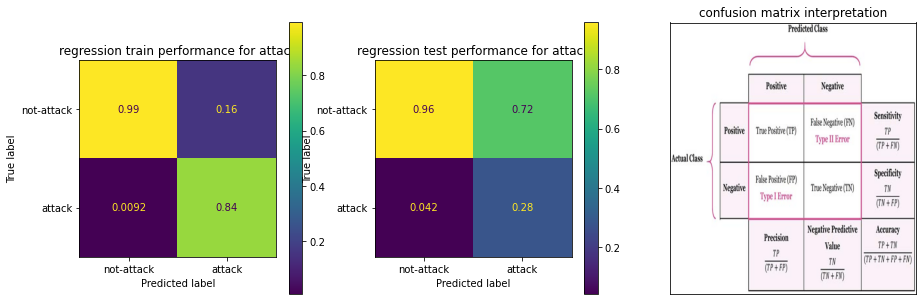

In [14]:
# Solution

imgconfusion = image.imread("confusion_mat.png")

# Training performance:
train_y_pred = reg.predict(X_train)
train_y_pred_bin = np.zeros((1,np.size(X_train[:,0])))
train_y_pred_bin[0,np.where(train_y_pred>0.4)] = 1

cm_train = confusion_matrix(y_train, train_y_pred_bin[0,], normalize = "pred")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = reg.predict(X_test)
test_y_pred_bin = np.zeros((1,np.size(X_test[:,0])))
test_y_pred_bin[0,np.where(test_y_pred>0.4)] = 1

cm_test = confusion_matrix(y_test, test_y_pred_bin[0,], normalize = "pred")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(131)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(132)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')

ax3 = plt.subplot(133)
ax3.imshow(imgconfusion, aspect='auto')
ax3.set_title('confusion matrix interpretation')
ax3.set_yticks([])
ax3.set_xticks([])


This approach reveals perhaps the most common problem faced in ML, namely overfitting. Here, the train performance of the linear model suggests that model has learnt to distinguish attack frames, however when applied on a held out test dataset, the model performance collapses.

Let's also observe this as a behavior raster:

<br>

#### Create a plot showing both the predicted behavior raster and actual behavior raster for attack

In [13]:
# Enter code here:

Text(0, 1.5, 'other frames')

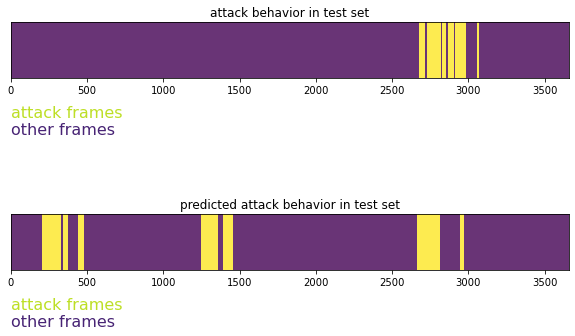

In [15]:
# Solution

# plot neural activity, showing frames of attack
plt.figure(figsize=[10,10])
ax1 = plt.subplot(311)
y_test_plot = np.expand_dims(y_test, axis=0)
ax1.imshow(y_test_plot, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior in test set')
ax1.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax1.text(0,1.5,'other frames',color = cmap(0.1),fontsize=16)

ax2 = plt.subplot(312)
ax2.imshow(test_y_pred_bin, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax2,aspect=10)
ax2.set_yticks([])
ax2.set_title('predicted attack behavior in test set')
ax2.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax2.text(0,1.5,'other frames',color = cmap(0.1),fontsize=16)

### 3 a) Overcoming Overfitting: LASSO or L2 Norm

To overcome overfitting, we apply regularization, a method where a penalty is introduced to curb overfitting. Different types of regularization exist, here we will apply LASSO (least absolute shrinkage and selection operator), a method that allows us to enforce sparsity in predicted weighted from linear regression. LASSO is also known as L2 norm regularization.

Most methods in machine learning always involving comparing a data point with it's predicted value. This can be written as: $y - \beta x $ in the case of linear regression. The goal of machine learning is to estimate a value of $\beta$ that minimizes this error that we also call a loss function. In regularization, we apply a penalty to this error, which for LASSO is as follows:

$(y - \beta x) + \alpha \sum_{i = 1}^{p} |\beta_i|$

The value of lamba specifies the amount of regularization and is selected by cross-validation, a process where the training data is split into several 'folds' or portions and the model is trained on some folds and tested on the held-out fold. This is a process called model selection and is vital to most ML methods.

Lasso can be implemented using sklearn's [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). 

#### Read the help sklearn [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) help page and generate a lasso model with cross validation below

In [17]:
# Enter code here

Text(0.5, 1.0, 'model selection for lasso')

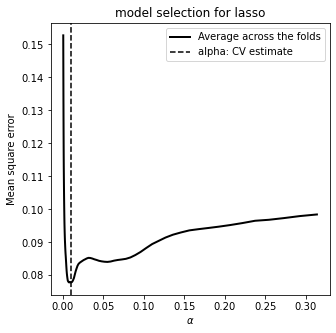

In [16]:
# Solution Lasso

from sklearn.linear_model import LassoCV
# from sklearn.linear_model import RidgeCV

# generate test split as last 1/3rd of data
X_train, X_test, y_train, y_test = train_test_split(neural_data.T, 
                                                    attack_vector[0,].T,
                                                    test_size=0.33, 
                                                    shuffle = False,
                                                    random_state=42)
# perform lasso
lasso = LassoCV(cv=5, random_state=0).fit(X_train, y_train)

plt.figure(figsize=(5, 5))
plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)

# plot a line for the optimal value of alpha
plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("model selection for lasso")

### 3 b) Lasso model performance

#### Use the code you wrote earlier to create predict data on the held out test set and create confusion matrices below

In [19]:
# Enter code here:

Text(0.5, 1.0, 'regression test performance for attack')

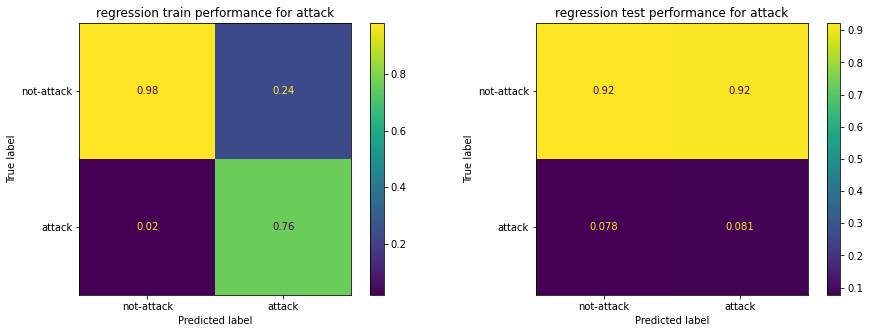

In [17]:
# Solution

# Training performance:
train_y_pred = lasso.predict(X_train)
train_y_pred_bin = np.zeros((1,np.size(X_train[:,0])))
train_y_pred_bin[0,np.where(train_y_pred>0.4)] = 1

cm_train = confusion_matrix(y_train, train_y_pred_bin[0,], normalize = "pred")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = lasso.predict(X_test)
test_y_pred_bin = np.zeros((1,np.size(X_test[:,0])))
test_y_pred_bin[0,np.where(test_y_pred>0.4)] = 1

cm_test = confusion_matrix(y_test, test_y_pred_bin[0,], normalize = "pred")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')


#### Let's also visualize the predicted and actual ocurrences of attack behavior in the test set below

#### Generate a behavior plot for both predicted and actual occurence of attack below

Text(0, 1.5, 'other frames')

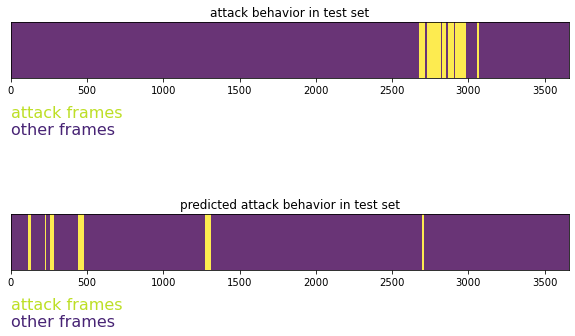

In [18]:
# Solution

# plot neural activity, showing frames of attack
plt.figure(figsize=[10,10])
ax1 = plt.subplot(311)
y_test_plot = np.expand_dims(y_test, axis=0)
ax1.imshow(y_test_plot, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior in test set')
ax1.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax1.text(0,1.5,'other frames',color = cmap(0.1),fontsize=16)

ax2 = plt.subplot(312)
ax2.imshow(test_y_pred_bin, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax2,aspect=10)
ax2.set_yticks([])
ax2.set_title('predicted attack behavior in test set')
ax2.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax2.text(0,1.5,'other frames',color = cmap(0.1),fontsize=16)

### 3 c) Overcoming overfitting: Ridge or L1 Norm

#### Oh no! LASSO isn't sufficient 😞 

No worries, let's try another type of reglurization! Like LASSO (or L2 norm), a second type of regularization called Ridge (or L1 norm) might be useful here!:

In LASSO, we added a penalty to our regression problem as follows:

LASSO or L2 norm: $(y - \beta x) + \alpha \sum_{i = 1}^{p} |\beta_i|$

In Ridge, we add a slightly different penalty: 

Ridge or L1 norm: $(y - \beta x) + \alpha \sum_{i = 1}^{p} \beta_i^2 $

Explain more about Ridge regression here (maybe link to websites explaining a geometric interpretation 

#### Let's implement Ridge Regression using sklearn's RidgeCV method, once again the $\alpha$ parameter is determined by cross validation


#### Note: unlike LassoCV, we need to provide a list of alpha values for Ridge CV. As a first example, try values from 0-200 in intervals of 1.

In [21]:
# Enter code here:

Text(0.5, 1.0, 'model selection for ridge')

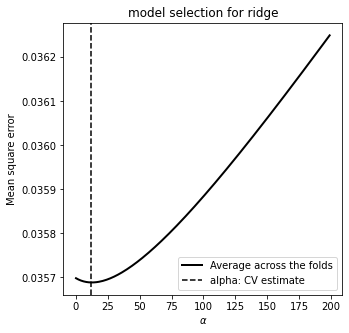

In [19]:
# Solution:

# Solution Ridge
# changing to Ridge to make it consistent with detailed implementation below:

# from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score

# generate test split as last 1/3rd of data
X_train, X_test, y_train, y_test = train_test_split(neural_data.T, 
                                                    attack_vector[0,].T,
                                                    test_size=0.3, 
                                                    shuffle = False,
                                                    random_state=42)

# Ridge requires us to provide a list of alpha values
alphas=np.arange(1e-3,200,1)
ridge = RidgeCV(alphas, store_cv_values=True).fit(X_train, y_train)

plt.figure(figsize=(5, 5))
plt.plot(
    ridge.alphas,
    ridge.cv_values_.mean(axis=0),
    color="black",
    label="Average across the folds",
    linewidth=2,
)

plt.axvline(ridge.alpha_ , linestyle="--", color="black", label="alpha: CV estimate")
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("model selection for ridge")

### 3 d) Ridge model performance

#### Use the code you wrote earlier to create predict data on the held out test set and create confusion matrices below

In [ ]:
# Enter code here

Text(0.5, 1.0, 'regression test performance for attack')

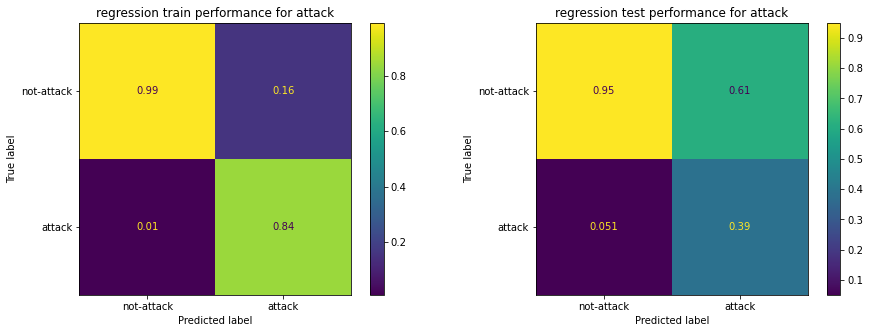

In [20]:
# Solution

# Training performance:
train_y_pred = ridge.predict(X_train)
train_y_pred_bin = np.zeros((1,np.size(X_train[:,0])))
train_y_pred_bin[0,np.where(train_y_pred>0.4)] = 1

cm_train = confusion_matrix(y_train, train_y_pred_bin[0,], normalize = "pred")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = ridge.predict(X_test)
test_y_pred_bin = np.zeros((1,np.size(X_test[:,0])))
test_y_pred_bin[0,np.where(test_y_pred>0.4)] = 1

cm_test = confusion_matrix(y_test, test_y_pred_bin[0,], normalize = "pred")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')


### 4) Class Imbalance

#### okay... so we're doing a little better than before, but still not perfect!

### Notice something about our data, our train & test splits contain very few examples of the label 'attack'! This problem called [class imbalance]() is very detrimental to our problem! 

There are two ways to fix this: We can either shuffle our data to ensure that the 'attack' label is uniformly sprinkled throughout the data or we can sub-sample or stratify our data to include equal numbers of attack and not-attack labels. Try either one out!
Hint: It's as simple as including an argument in the function train_test_split

#### Redo regression (either Ridge or LASSO), but now including shuffled or sub-sampled classes below

In [ ]:
# Enter code here

Text(0.5, 1.0, 'regression test performance for attack')

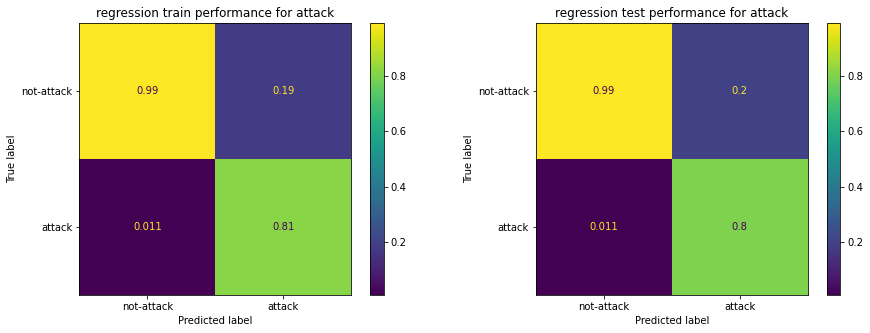

In [21]:
from sklearn.model_selection import cross_val_score

# generate test split as last 1/3rd of data
X_train, X_test, y_train, y_test = train_test_split(neural_data.T, 
                                                    attack_vector[0,].T,
                                                    test_size=0.3, 
                                                    shuffle = True,
                                                    random_state=42)

# Ridge requires us to provide a list of alpha values
alphas=np.arange(1e-3,200,1)
ridge = RidgeCV(alphas, store_cv_values=True).fit(X_train, y_train)


# Training performance:
train_y_pred = ridge.predict(X_train)
train_y_pred_bin = np.zeros((1,np.size(X_train[:,0])))
train_y_pred_bin[0,np.where(train_y_pred>0.4)] = 1

cm_train = confusion_matrix(y_train, train_y_pred_bin[0,], normalize = "pred")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = ridge.predict(X_test)
test_y_pred_bin = np.zeros((1,np.size(X_test[:,0])))
test_y_pred_bin[0,np.where(test_y_pred>0.4)] = 1

cm_test = confusion_matrix(y_test, test_y_pred_bin[0,], normalize = "pred")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')


### YAY!! Our decoder works!! 

Let's finally make a plot showing our entire dataset: the attack annotation, neural data and predicted attack labels on all data

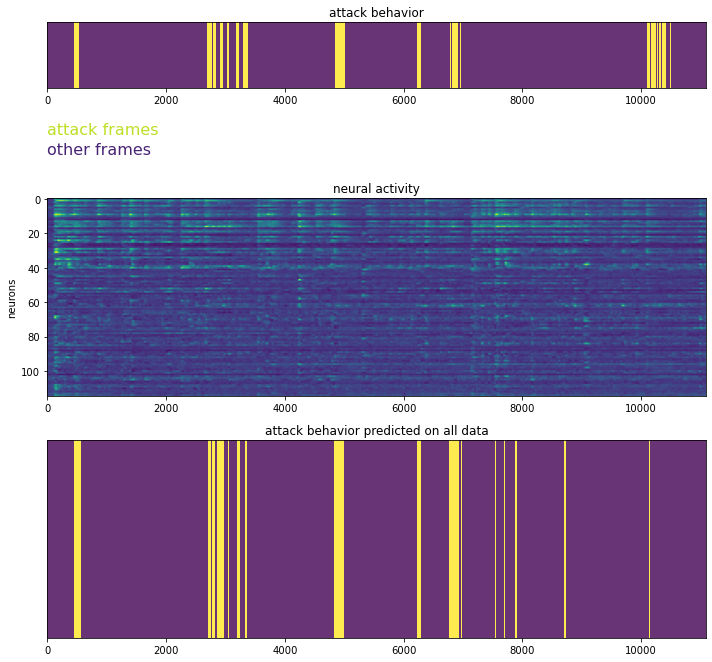

In [22]:
# Solution: 

# plot neural activity, showing frames of attack
all_y_pred = lasso.predict(neural_data.T)
all_y_pred_bin = np.zeros((1,np.size(neural_data[0,:])))
all_y_pred_bin[0,np.where(all_y_pred>0.4)] = 1

plt.figure(figsize=[10,10])
ax1 = plt.subplot(311)
cmap = matplotlib.cm.get_cmap('viridis')

ax1.imshow(attack_vector, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax1.set_yticks([])
ax1.set_title('attack behavior')
ax1.text(0,1.2,'attack frames',color = cmap(0.9),fontsize=16)
ax1.text(0,1.5,'other frames',color = cmap(0.1),fontsize=16)

ax2 = plt.subplot(312)
ax2.imshow(neural_data, aspect='auto')
ax2.set_title('neural activity')
ax2.set_ylabel('neurons')

ax3 = plt.subplot(313)
ax3.imshow(all_y_pred_bin, aspect='auto', alpha = 0.8, interpolation = 'nearest')
forceAspect(ax1,aspect=10)
ax3.set_yticks([])
ax3.set_title('attack behavior predicted on all data')

plt.tight_layout() 

### 5) Logistic Regression

Linear regression is a great simple tool to quantifying correlations between neural activity and behavior. However, the output of regression wasn't a class label. Other methods such as logistic regression (and many others such as SVMs & Random Forests that you will encounter with Ann later) are better suited to classification problems.

Logistic regression as a non-linear step between your prediction and coefficients. We start with a linear function: $f(x) = \beta_1 x_1 + \beta_2 x_2 ... + \beta_n x_n $ which is then passed into a sigmoid function $p(x) = 1/(1+exp(-f(x))$. Thus the output of logistic regression is a probability between 0-1 of the prediction. Thus can be thresholded to produce a class label.

sklearn makes it very easy to perform Logistic regression using [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) that performs a built-in regularization step. Methods like logistic regression are more powerful than Linear regressison and can find an accurate solution sometimes even in the presence of a class imbalance

#### Let's implement Logistic Regression using sklearn below

In [ ]:
# Enter code here:


C:\Users\Adi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Text(0.5, 1.0, 'regression test performance for attack')

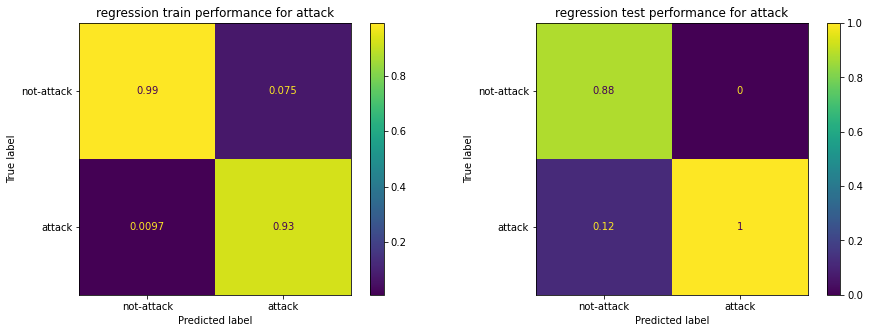

In [23]:
# Solution:

# generate test split as last 1/3rd of data
X_train, X_test, y_train, y_test = train_test_split(neural_data.T, 
                                                    attack_vector[0,].T,
                                                    test_size=0.2, 
                                                    shuffle = False,
                                                    random_state=42)

# Ridge requires us to provide a list of alpha values
alphas=np.arange(1e-3,200,1)
# logistic = LogisticRegressionCV(cv=5, penalty='l1',random_state=0, solver='saga').fit(X_train, y_train)
logistic = LogisticRegression(penalty='l1',random_state=0, solver='saga').fit(X_train, y_train)

# Training performance:
train_y_pred = logistic.predict(X_train)

cm_train = confusion_matrix(y_train, train_y_pred, normalize = "pred")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = logistic.predict(X_test)

cm_test = confusion_matrix(y_test, test_y_pred, normalize = "pred")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')

### 6 a) Digging deeper and implementing regression from scratch:

We've implemented linear regression with sklearn's helpful functions, but how does regression actually work?

Let's gain an understanding by coding out the steps behind regression.
As we saw earlier, the goal of regression is to predict a variable y (behavior) as a linear combination of x (neural activity). This can be written as:

$y = \beta X$

Notice here that we switch to matrix notation, here $\beta$ is no longer a single number but a vector as long as the number of neurons (n). Hence it's dimensionas as $(1 x n)$. X here is also a matrix with dimensions $(n x t)$, where t is the number of time points.

There are many algorithms that allow us to find the $\beta's$ that make our weights. Some methods are iterative, using a loss function as defined earlier and reducing error over time. Luckily, linear regression also has an analytical solution which can be implemented in a single step!

The solution here is simply: 

$\beta = (X^{T} X)^{-1} X^{T} y$

Why is that?? We'll explain later but if you're curious you can read about the mathematical steps [here]():

Let's try this out!

We're going to use [Object Oriented Programming](https://en.wikipedia.org/wiki/Object-oriented_programming) here and create a class which can implement this solution for us 

#### Fill in the function below to implement linear regression 

In [36]:
# Enter code here

class LinearRegClosedSolution(object):
    
    def __int__(self):
        self.betas = []
        
    def fit(self, X, y):
        
        X = self._concatenate_ones(X)
        self.betas = # Enter equation for beta here
        
    def predict(self, X):
        b = self.betas
        prediction = # Enter equation for finding solution here
        return prediction
    
    def _concatenate_ones(self, X):
        ones = np.ones(shape = X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X),1)

In [24]:
# Solution

class LinearRegClosedSolution(object):
    def __int__(self):
        self.betas = []
          
    def fit(self, X, y):
        if len(X.shape) == 1: X = self._reshape_x(X)
            
        X = self._concatenate_ones(X)
        self.betas = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(y) 
#         self.betas = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
    
    def predict(self, X):
        b0 = self.betas[0]
        b = self.betas[1:]
        prediction = b0
        
        for xi, bi in zip(X, b): prediction += (bi*xi)
        return prediction
    
    def _reshape_x(self,X):
        return X.reshape(-1,1)
    
    def _concatenate_ones(self, X):
        ones = np.ones(shape = X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X),1)

### 6 b) Testing our regression function!

Now that we've implemented linear regression, let's test it out! 

#### Split the data into train and test folds and use the class created above to implement linear regression

#### Remember to stratify your classes and correct for class imbalance here:


In [ ]:
# Enter code to resample your data here:

In [25]:
# Solution (not elegant for now):
atk_idx = np.where(attack_vector[0,] == 1)
nonatk_idx = np.where(attack_vector[0,] == 0)

newnonatk_idx = np.random.choice(nonatk_idx[0],atk_idx[0].shape[0])

new_X = np.concatenate((neural_data[:,atk_idx[0]],neural_data[:,newnonatk_idx]), axis=1)
new_y = np.concatenate((np.ones(atk_idx[0].shape[0]),np.zeros(atk_idx[0].shape[0])), axis=0)

In [213]:
# Enter code to perform regression here


In [26]:
# Solution

X_train, X_test, y_train, y_test = train_test_split(new_X.T, 
                                                    new_y.T,
                                                    test_size=0.4, 
                                                    shuffle = True,
                                                    random_state=42)

model = LinearRegClosedSolution()
model.fit(X_train, y_train)


#### Now predict the test data using our closed form function and generate a confusion matrix

In [124]:
# Enter code here

Text(0.5, 1.0, 'regression test performance for attack')

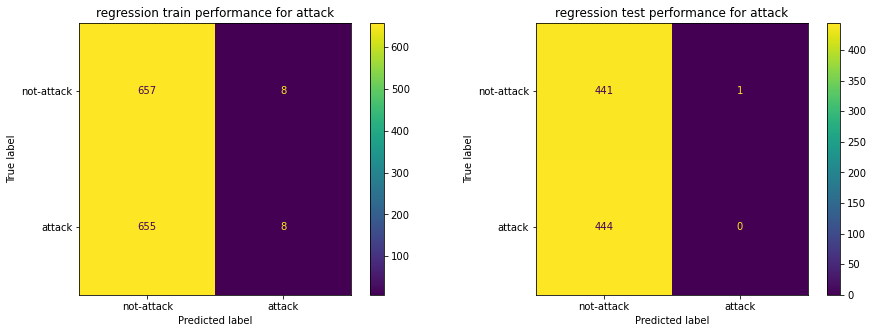

In [27]:
# Solution 

# Training performance:
train_y_pred = model.predict(X_train)
train_y_pred_bin = np.zeros((1,np.size(X_train[:,0])))
train_y_pred_bin[0,np.where(train_y_pred>0.4)] = 1

cm_train = confusion_matrix(y_train, train_y_pred_bin[0,])
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = model.predict(X_test)
test_y_pred_bin = np.zeros((1,np.size(X_test[:,0])))
test_y_pred_bin[0,np.where(test_y_pred>0.4)] = 1

cm_test = confusion_matrix(y_test, test_y_pred_bin[0,])
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')

### 7) Implementing regularization from scratch

We once again encounter overfitting in our regression problem. To overcome this, we resort to regularization!

Ridge regression is a form of regularization that possess an analytical solution which is as follows:

$\beta = (X^{T} X + \lambda I)^{-1} X^{T} y$

where $\lambda$ is a parameter we need to determine using cross validation once more!

Let's implement a function to perform ridge regression below:

#### Implement a ridge regression class below where you can feed in a single regularization parameter $\lambda$:

In [153]:
# Enter code here


class LinearRegRidgeClosedSolution(object):
    def __int__(self):
        self.betas = []
          
    def fit(self, X, y, regLamba):
        X = self._concatenate_ones(X)
        self.betas = # Enter equation for beta here
    
    def predict(self, X):
        # Enter equation for finding solution here
        return prediction
    
    def _concatenate_ones(self, X):
        ones = np.ones(shape = X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X),1)

In [28]:
# Solution

class LinearRegRidgeClosedSolution(object):
    def __int__(self):
        self.betas = []
          
    def fit(self, X, y, regLamba):
        X = self._concatenate_ones(X)
        self.betas = np.linalg.inv(X.transpose().dot(X) + regLamba*np.identity(X.shape[1])).dot(X.transpose()).dot(y) 
    
    def predict(self, X):
        b0 = self.betas[0]
        b = self.betas[1:]
        prediction = b0
        
        for xi, bi in zip(X, b): prediction += (bi*xi)
        return prediction
    
    def _concatenate_ones(self, X):
        ones = np.ones(shape = X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X),1)

### 4 b) Testing our regression function!

Now that we've implemented linear regression with regularization, let's test it out! 

#### Split the data into train and test folds and use the class created above to implement linear regression


In [ ]:
# Enter code here

In [29]:
# Solution

X_train, X_test, y_train, y_test = train_test_split(neural_data.T, 
                                                    attack_vector[0,].T,
                                                    test_size=0.3, 
                                                    shuffle = True,
                                                    random_state=42)

modelridge = LinearRegRidgeClosedSolution()
X_train.shape

modelridge.fit(X_train, y_train,10)


#### Now predict the test data using our closed form function and generate a confusion matrix

In [ ]:
# Enter code here

In [31]:
# Solution 

# Training performance:
train_y_pred = modelridge.predict(X_train)
train_y_pred_bin = np.zeros((1,np.size(X_train[:,0])))
train_y_pred_bin[0,np.where(train_y_pred>0.4)] = 1

cm_train = confusion_matrix(y_train, train_y_pred_bin[0,], normalize = "pred")
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, 
                                    display_labels=["not-attack", "attack"])

# Testing performance:
test_y_pred = modelridge.predict(X_test)
test_y_pred_bin = np.zeros((1,np.size(X_test[:,0])))
test_y_pred_bin[0,np.where(test_y_pred>0.4)] = 1

cm_test = confusion_matrix(y_test, test_y_pred_bin[0,], normalize = "pred")
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, 
                                   display_labels=["not-attack", "attack"])

# # Plot performance as confusion matrices
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
disp_train.plot(ax = ax1)
ax1.set_title('regression train performance for attack')

ax2 = plt.subplot(122)
disp_test.plot(ax = ax2)
ax2.set_title('regression test performance for attack')

### YAY! Our regularization worked!

#### But why did it?

## Go into details of math here: